In [71]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average_cumsum(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

class state:
    def __init__(self, dt_, duration_, x0=0.0, x_dot0=0.0):
        self.dt = dt_
        self.duration = duration_
        self._x = np.zeros(int(self.duration / self.dt))
        self._x_dot = np.zeros(int(self.duration / self.dt))
        self._x[0] = x0
        self._x_dot[0] = x_dot0


def sign_matrix(X):
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i, j] > 0:
                Y[i, j] = 1
            elif X[i, j] < 0:
                Y[i, j] = -1
            else:
                Y[i, j] = 0
    return Y

matrix_A = np.matrix(
    [
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]
)

matrix_B = np.matrix(
    [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
)

matrix_G = np.matrix([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])

def update_Matrix_A(mc, mt, bt, br, l, l_dot, theta, theta_dot, matrix_A):
    matrix_A[1, 1] = -bt / mt
    matrix_A[1, 3] = -br * np.sin(theta) / mt
    matrix_A[3, 1] = -bt * np.sin(theta) / mt
    matrix_A[3, 3] = -(mc * (np.sin(theta)) ** 2 / mt + 1) * (br / mt)
    matrix_A[3, 5] = l * theta_dot
    matrix_A[5, 1] = -bt * np.cos(theta) / (mt * l)
    matrix_A[5, 3] = -br * np.sin(theta) * np.cos(theta) / (mt * l)
    matrix_A[5, 5] = -2 * l_dot / l

def update_Matrix_B(mc, mt, l, theta, matrix_B):
    matrix_B[1, 0] = 1 / mt
    matrix_B[1, 1] = np.sin(theta) / mt
    matrix_B[3, 0] = np.sin(theta) / mt
    matrix_B[3, 1] = (mc * (np.sin(theta)) ** 2 / mt + 1) / mc
    matrix_B[5, 0] = np.cos(theta) / (mt * l)
    matrix_B[5, 1] = np.sin(theta) * np.cos(theta) / (mt * l)

def update_Matrix_G(g, l, theta, matrix_G):
    matrix_G[1, 0] = 0.0
    matrix_G[3, 0] = g * np.cos(theta)
    matrix_G[5, 0] = -g * np.sin(theta) / l

def matrix_Lambda(lambda1, lambda2):
    matrix_Lambda = np.matrix([[lambda1, 0.0, 0.0], [0.0, lambda2, 0.0]])
    return matrix_Lambda

def matrix_Alpha(alpha1, alpha2):
    matrix_alpha = np.matrix([[alpha1], [alpha2]])
    return matrix_alpha

In [72]:
generate_variation = []
variation_number = 5

x_range = [0.0, 2.0]
l_range = [0.2, 1.8]
theta_range = [0.0 * np.pi / 180.0, 45.0 * np.pi / 180.0]
mc_range = [0.4, 1.6]

for i in range (variation_number):
    temp_ = [0.0, 0.0, 0.0, 0.0]
    temp_[0] = round(np.random.uniform(x_range[0], x_range[1]), 2)
    temp_[1] = round(np.random.uniform(l_range[0], l_range[1]), 2)
    temp_[2] = round(np.random.uniform(theta_range[0], theta_range[1]), 2)
    temp_[3] = round(np.random.uniform(mc_range[0], mc_range[1]), 2)
    generate_variation.append(temp_)

print(generate_variation)


[[1.81, 0.75, 0.44, 1.3], [1.23, 0.2, 0.26, 1.28], [0.74, 1.77, 0.14, 1.08], [0.28, 1.3, 0.67, 1.18], [1.82, 0.97, 0.32, 0.81]]


In [73]:
# Physical Parameter
mc = 2.0
mt = 1.0
bt = 5.0
br = 5.0
g = 9.81

control_limit = 2 * mc * g

x_max_error = 0.01
x_dot_max_steady_state = 0.01

l_max_error = 0.01
l_dot_max_steady_state = 0.01

theta_max_error = 0.00005
theta_dot_max_steady_state = 0.0001

# Simulation Parameter
dt = 0.001
timeout_duration = 60.0
steady_state_checking_duration_window = 1.0

k = 1.0
lambda1 = 0.75
lambda2 = 0.7
alpha1 = 1.5
alpha2 = 0.0

matrix_lambda = np.matrix([[lambda1, 0.0, 0.0], [0.0, lambda2, 0.0]])
matrix_alpha = np.matrix([[alpha1], [alpha2]])
matrix_I = np.matrix([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

In [74]:
x = []
l = []
theta = []
x_dot = []
l_dot = []
theta_dot = []
Sx = []
Sl = []
Fx = []
Fl = []

for i in range (variation_number):
    x_initial = generate_variation[i][0]
    l_initial = generate_variation[i][1]
    theta_initial = generate_variation[i][2]
    mc = generate_variation[i][3]

    y_initial = np.matrix([[x_initial], [l_initial], [theta_initial]])
    y_desired = np.matrix([[1.0], [1.0], [0.0]])

    x_ = [x_initial]
    l_ = [l_initial]
    theta_ = [theta_initial]
    x_dot_ = [0.0]
    l_dot_ = [0.0]
    theta_dot_ = [0.0]
    Sx_ = [0.0]
    Sl_ = [0.0]
    Fx_ = [0.0]
    Fl_ = [0.0]

    j = 0
    while j < int(timeout_duration/dt):
        update_Matrix_A(
            mc, mt, bt, br, l_[j], l_dot_[j], theta_[j], theta_dot_[j], matrix_A
        )

        update_Matrix_B(mc, mt, l_[j], theta_[j], matrix_B)

        update_Matrix_G(g, l_[j], theta_[j], matrix_G)

        matrix_A_cap = np.matrix(
            [
                [matrix_A[1, 1], matrix_A[1, 3], matrix_A[1, 5]],
                [matrix_A[3, 1], matrix_A[3, 3], matrix_A[3, 5]],
            ]
        )

        matrix_B_cap = np.matrix(
            [
                [matrix_B[1, 0], matrix_B[1, 1]],
                [matrix_B[3, 0], matrix_B[3, 1]],
            ]
        )

        matrix_G_cap = np.matrix([[matrix_G[1, 0]], [matrix_G[3, 0]]])

        y = np.matrix([[x_[j]], [l_[j]], [theta_[j]]])
        y_dot = np.matrix([[x_dot_[j]], [l_dot_[j]], [theta_dot_[j]]])

        sliding_surface_now = np.matrix([[Sx_[j]], [Sl_[j]]])
        sliding_surface_now = (
            matrix_lambda * (y_desired - y) # type: ignore
            - matrix_I * y_dot
            - matrix_alpha * theta_[j]
        )

        control_now = np.matrix([[Fx_[j]], [Fl_[j]]])
        control_now = np.linalg.inv(matrix_B_cap) * (
            -np.matmul((matrix_A_cap + matrix_lambda), y_dot)
            - matrix_G_cap
            - matrix_alpha * theta_dot_[j]
        ) + k * sign_matrix(sliding_surface_now)
        control_now = np.clip(control_now, -control_limit, control_limit)

        state_now = np.matrix(
            [
                [x_[j]],
                [x_dot_[j]],
                [l_[j]],
                [l_dot_[j]],
                [theta_[j]],
                [theta_dot_[j]],
            ]
        )

        state_now = state_now + dt * (
            matrix_A * state_now + matrix_B * control_now + matrix_G
        )

        x_.append(state_now[0, 0])
        x_dot_.append(state_now[1, 0])
        l_.append(state_now[2, 0])
        l_dot_.append(state_now[3, 0])
        theta_.append(state_now[4, 0])
        theta_dot_.append(state_now[5, 0])

        Fx_.append(control_now[0, 0])
        Fl_.append(control_now[1, 0])

        Sx_.append(sliding_surface_now[0, 0])
        Sl_.append(sliding_surface_now[1, 0])

        if (j % 100):
            print("Variation ", i + 1, ": Progress: ", round(j*dt / timeout_duration * 100, 1), "%", end="\r")

        j += 1
    
    x.append(x_)
    l.append(l_)
    theta.append(theta_)
    x_dot.append(x_dot_)
    l_dot.append(l_dot_)
    theta_dot.append(theta_dot_)
    Sx.append(Sx_)
    Sl.append(Sl_)
    Fx.append(Fx_)
    Fl.append(Fl_)



KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


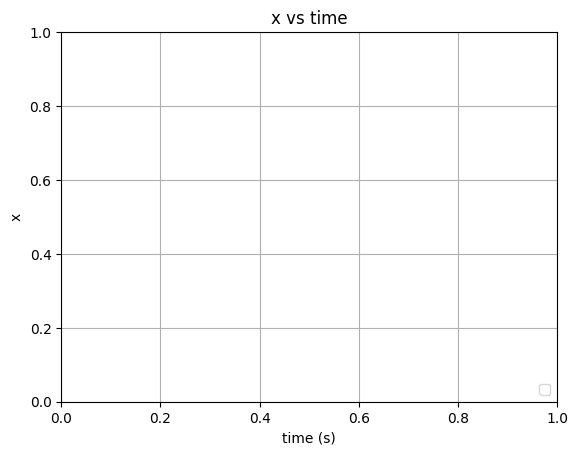

In [ ]:
def multi_plot(state_version, state_name = "state", variation_=[0.0, 0.0, 0.0, 0.0]):
    for i in range(len(state_version)):
        time = np.arange(0, len(state_version[i])*dt, dt)
        r = 255 * (i + 1) / len(state_version)
        g = 255 * (len(state_version) - i) / len(state_version)
        b = 255 * (i + 1) / len(state_version)
        rgb_color = (r / 255, g / 255, b / 255)

        variation_label = (
            "Var"
            + str(i + 1)
            + ": x_init"
            + " = "
            + str(variation_[0])
            + ", l_init"
            + " = "
            + str(variation_[1])
            + ", theta_init"
            + " = "
            + str(variation_[2])
            + ", mc"
            + " = "
            + str(variation_[3])
        )

        plt.plot(time, state_version[i], color=rgb_color, label = variation_label)
    plt.legend(loc="lower right")
    plt.xlabel("time (s)")
    plt.ylabel(state_name)
    plt.title(state_name + " vs time")
    plt.grid(True)
    plt.show()


multi_plot(x, state_name="x", variation_= generate_variation[0])
# multi_plot(l, state_name="l", variation_= generate_variation[0])
# multi_plot(theta, state_name="theta", variation_= generate_variation[0])
# multi_plot(x_dot, state_name="x_dot", variation_= generate_variation[0])
# multi_plot(l_dot, state_name="l_dot", variation_= generate_variation[0])
# multi_plot(theta_dot, state_name="theta_dot", variation_= generate_variation[0])
# multi_plot(Sx, state_name="Sx", variation_= generate_variation[0])
# multi_plot(Sl, state_name="Sl", variation_= generate_variation[0])
# multi_plot(Fx, state_name="Fx", variation_= generate_variation[0])
# multi_plot(Fl, state_name="Fl", variation_= generate_variation[0])
